In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# INSTALL & IMPORT LIBRARY

In [2]:
!pip install underthesea
!pip install transformers
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 53.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for v

In [3]:
from bs4 import BeautifulSoup
import numpy as np
import re
# from underthesea import word_tokenize
from keras.utils import to_categorical
from transformers import AutoTokenizer
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
import pandas as pd

In [4]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


--2023-06-17 13:14:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

VnCoreNLP-1.2.jar   100%[===================>]  26.14M   166MB/s    in 0.2s    

2023-06-17 13:14:20 (166 MB/s) - ‘VnCoreNLP-1.2.jar’ saved [27412703/27412703]

--2023-06-17 13:14:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [5]:
from vncorenlp import VnCoreNLP


# LOAD DATA

In [6]:
class TextNormalize:
    def __init__(self):
        self.vowels_to_ids = {}
        self.vowels_table = [
            ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
            ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
            ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
            ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
            ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
            ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
            ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
            ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'o'],
            ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
            ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
            ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
            ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
        ]
        pass

    def createVowelsTable(self):
        """Create Vowels Table"""
        for i in range(len(self.vowels_table)):
            for j in range(len(self.vowels_table[i]) - 1):
                self.vowels_to_ids[self.vowels_table[i][j]] = (i, j)

    def IsValidVietnameseWord(self,word):
        """Nguyên âm chỉ có thể đứng chung với nguyên âm. Một từ không thể có 2 nguyên âm cách nhau bởi 1 phụ âm"""
        chars = list(word)
        #nguyen am
        vowel_index = -1
        for i in range(len(chars)):
            idx_vowel_table = self.vowels_to_ids.get(chars[i],(-1,-1))[0]
            if idx_vowel_table != -1:
                if vowel_index == -1:
                    vowel_index = i
                else:
                    if i - vowel_index != 1:
                        return False
                    vowel_index = i
        return True

    def WordStandardized(self,word):
        """Standardize Word"""
        if not self.IsValidVietnameseWord(word):
            return word

        chars = list(word)
        vowel_indexes = []

        # tìm vị trí nguyên âm
        qu_or_gi = False
        thanh_dieu = 0
        for i in range(len(chars)):
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[i],(-1,-1))
            if vowel_table_row == -1 :
                continue
            # qu
            if vowel_table_row == 9:
                if i != 0 and chars[i-1] == 'q':
                    chars[i] = 'u'
                    qu_or_gi = True
            # gi
            elif vowel_table_row == 5:
                if i != 0 and chars[i-1] == 'g':
                    chars[i] = 'i'
                    qu_or_gi = True

            # có chứa thanh điệu
            if vowel_table_col != 0:
                thanh_dieu = vowel_table_col
                chars[i] = self.vowels_table[vowel_table_row][0]

            vowel_indexes.append(i)
        # 1 nguyên âm
        if len(vowel_indexes) == 1:
            c = chars[vowel_indexes[0]]
            chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
            return ''.join(chars)

        for idx_vowel in vowel_indexes:
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[idx_vowel],(-1,-1))
            #ê, ơ, ô
            if vowel_table_row == 4 or vowel_table_row == 7 or vowel_table_row == 8:
                c = chars[idx_vowel]
                chars[idx_vowel] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # kiểm tra qu và gi, 2-3 nguyên âm thì nguyên âm thứ 2 chứa dấu
            if qu_or_gi:
                if len(vowel_indexes) == 2 or len(vowel_indexes) == 3:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # 2 nguyên âm
            if len(vowel_indexes) == 2:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[0]]
                    chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            elif len(vowel_indexes) == 3:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

        return ''.join(chars)

    def normalize(self,text):

        #Chuyen sang viet thuong
        text = text.lower()

        # Rút gọn từ kéo dài
        text = re.sub(r'(\w)\1+',r'\1',text)

        # xóa các emoji dư thừa
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'',text) # no emoji

        text = text.split()
        # chuẩn hóa thanh điệu
        for i in range(len(text)):
            text[i] = self.WordStandardized(text[i])

        text = ' '.join(text)

        # xóa space d
        text = re.sub(r"( )\1+",r'\1',text)
        text = re.sub(r"[:)^@!`~%;?(\+\-\'\"]+",r'',text)

        # remove hastag
        text = re.sub("(@[A-Za-z0-9]+)|(#[0-9A-Za-z]+)"," ", text)
        return text

In [7]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
)


In [8]:
class LoadSentenceAspectData():
    def __init__(self, file_path):
        self.file_path = file_path

        self.data = pd.read_json(file_path)
        self.data = self.data.dropna()
        self.X = []
        self.aspect = []
        self.polarity = []
    def load(self,):
        _len = len(self.data)
        for i in range(_len):

            aspect_terms = self.data.iloc[i,2] #label

            x = self.data.iloc[i,0].strip() #text
            len_aspect = len(self.data.iloc[i,2])
            for j in range(len_aspect):
              aspect = self.data.iloc[i,2][j]['text'] #aspect
              label = self.data.iloc[i,2][j]['labels'][0] #polarity
              if label == 'Conflict':
                continue

              self.aspect.append(convert_unicode(aspect))
              self.polarity.append(label)
              self.X.append(convert_unicode(x))
        return self.X,self.aspect,self.polarity

In [9]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/data.json")
sentences, aspects,polarities = sent_asp_data.load()

In [10]:
len(sentences),len(polarities)

(18023, 18023)

In [11]:
np.unique(polarities)

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [12]:
# nếu nhiều ý positive hơn neutral 1 tí thì làm tròn positive
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [13]:
def remove_duplicate_aspects(sentences,aspects,polarities):
  """
    Remove and get mean with duplicate aspects
  """
  df = pd.DataFrame({"Sentences":sentences,"Aspect":aspects,"Polarity":polarities})
  df['Polarity'] = df['Polarity'].apply(lambda x: tag2idx[x])
  gp = df.groupby(by = ['Sentences',"Aspect"])['Polarity'].agg(lambda x: np.ceil(pd.Series.mean(x))).reset_index()
  gp['Polarity'] = gp['Polarity'].astype(int).apply(lambda x: idx2tag[x])

  sents = gp['Sentences'].values
  asps = gp['Aspect'].values
  polars = gp['Polarity'].values
  return sents,asps,polars


In [14]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)
len(sentences),len(aspects),len(polarities)

(17221, 17221, 17221)

In [15]:
sentences[:5],aspects[:5],polarities[:5]

(array(['# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng ngọt và đậm vị cua, bánh đa mềm, thịt chả mọc mọi thứ k chê vào đâu đc, lại còn nhiều. ( khéo ăn hết bánh đa r mà vẫn chưa hết thịt vs chả)Đây là lúc mình còn chưa ăn, tức là chưa cho ớt xào vào mà màu đã hấp dẫn vãi Bên kia lúc bưng ra bát bánh đa trắng phớ, hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
        '# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng n

In [16]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [17]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [18]:
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [19]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc dùng ngọt và đậm vị cua , bánh_đa mềm , thịt chả mọc mọi thứ k chê vào đâu đc , lại còn nhiều . khéo ăn hết bánh_đa r mà vẫn chưa hết thịt vs chảđây là lúc mình còn chưa ăn , tức_là chưa cho ớt xào vào mà màu đã hấp_dẫn vãi bên kia lúc bưng ra bát bánh_đa trắng phớ , hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
   'nc dùng'),
  ('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc 

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_pair, polarities, test_size=0.2, random_state=42)

In [21]:
X_train[:5],y_train[:5]

([('thơm ngon đến miếng cuối_cùng . ngan chắc , đậm thịt , nước dùng ngọt đậm vị thịt . nhìn cái tủ chật_cứng mười mấy con ngan to_đùng với nồi nước dùng đầy xương đã thấy ngọt rồi ý . ăn bún , miến hay cổ cánh , ngan chặt đều có măng tiết , giá_trần đi kèm . chung_quy là ngon không cưỡng nổi , tiếc là quán chỉ bán từ 5h chiều đến tối nên buổi trưa k được thưởng_thức , nghĩ_lại thèm , chẹp chẹp',
   'giá_trần'),
  ('bánh_canh cua tô đầy_đủ như này là 50k . gồm tôm , thịt heo , thịt cua , gạch cua , chả cua . bánh_canh thì ít mà đồ_ăn thì nhiều hơi mặn 1 tẹo , nhớ ăn chung với quẩy nha . bánh_canh 320 võ văn tần .',
   'thịt cua'),
  ('lòng heo làm sạch kĩ hok bị hôi , béo béo dai giòn chấm với nước_mắm mặn bao đã , đặc_biệt có dồi huyết béo béo , thơm vì có rau_thơm và hành phi trộn chung cô chủ quán niềm_nở và nhiệt_tình quán này dậm chất miền bắc dành cho các bạn mún nhớ về quê nhà nha',
   'hành phi'),
  ('nghe tới bún_bò gánh cũng từ lâu rồi mà hôm_nay mới được ăn lần đầu . ngon lắ

In [22]:
f= open('/content/drive/MyDrive/Đồ án KHDL/word2vec_vi_words_100dims.txt','r',encoding='utf-8')
words = []
embedding_words = {}

i = 0
for line in f:
  if i == 0:
    i+= 1
    continue
  value = line.split(' ')
  word = value[0]
  words.append(word)
  try:
    coefs = value[1:]
    embedding_words[word] = np.asarray(coefs,dtype=np.float32)
  except:
    pass


In [23]:
num_word = len(words)
num_word

1587507

In [24]:
word2idx = {w:i for i,w in enumerate(words,start = 2)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1
idx2word = {i:w for w,i in word2idx.items()}

In [25]:
def encoded(X,_len):
  x_new = []
  for sent in X:
    te = []
    for word in sent.split():
      try:
        te.append(word2idx[word])
      except:
        te.append(word2idx["UNK"])
    x_new.append(te)
  x_new = pad_sequences(x_new,maxlen=_len,padding='post',truncating = 'post',value = word2idx['PAD'])
  return x_new

In [26]:
X_train_text, X_train_aspect = np.asarray(X_train)[:,0],np.asarray(X_train)[:,1]
X_dev_text, X_dev_aspect = np.asarray(X_dev)[:,0],np.asarray(X_dev)[:,1]

<Axes: >

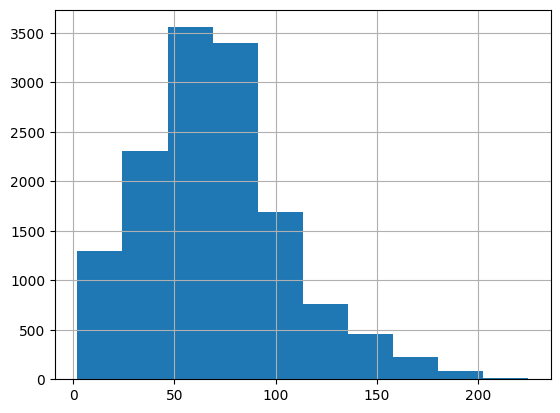

In [27]:
pd.DataFrame(X_train_text)[0].apply(lambda x: len(x.split())).hist()

In [ ]:
X_train_text_encoded = encoded(X_train_text,130)
X_dev_text_encoded = encoded(X_dev_text,130)

In [ ]:
X_train_text_encoded

array([[ 1982,  2755,   278, ...,     0,     0,     0],
       [   86,    50,   237, ...,     0,     0,     0],
       [  940,   335,   243, ...,     0,     0,     0],
       ...,
       [   99,  6830,   598, ...,     0,     0,     0],
       [  101,  2253,     6, ...,     0,     0,     0],
       [ 6859,  2158, 82419, ...,     0,     0,     0]], dtype=int32)

<Axes: >

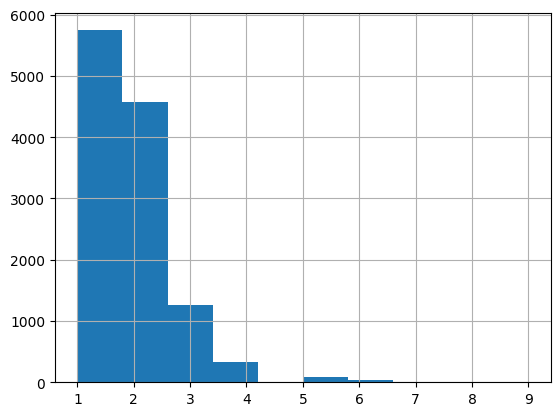

In [ ]:
pd.DataFrame(X_train_aspect)[0].apply(lambda x: len(x.split())).hist()

In [ ]:
X_train_aspect_encoded = encoded(X_train_aspect,3)
X_dev_aspect_encoded = encoded(X_dev_aspect,3)

In [ ]:
y_train_encoded = [tag2idx[y] for y in y_train]
y_train_encoded = to_categorical(y_train_encoded,num_classes = len(tag2idx))

y_dev_encoded = [tag2idx[y] for y in y_dev]
y_dev_encoded = to_categorical(y_dev_encoded,num_classes = len(tag2idx))

# MODEL

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
from keras.initializers import Constant


In [29]:
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPool1D, Flatten, concatenate, Dense, \
    LSTM, Bidirectional, Activation, MaxPooling1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, \
    TimeDistributed, Permute, multiply, Lambda, add, Masking, BatchNormalization, Softmax, Reshape, ReLU, \
    ZeroPadding1D, subtract
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import keras.backend as K
import tensorflow as tf


In [30]:
class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Content Attention mechanism.
        Supports Masking.
        """

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert type(input_shape) == list

        self.steps = input_shape[0][1]

        self.W = self.add_weight(shape = (input_shape[0][-1], input_shape[1][-1]),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape = (1,),
                                     initializer='zeros',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        else:
            self.b = None


        self.built = True

    def compute_mask(self, input_tensor, mask=None):
        assert type(input_tensor) == list
        assert type(mask) == list
        return None

    def call(self, input_tensor, mask=None):
        x = input_tensor[0]
        aspect = input_tensor[1]
        mask = mask[0]

        aspect = K.transpose(K.dot(self.W, K.transpose(aspect)))
        aspect = K.expand_dims(aspect, axis=-2)
        aspect = K.repeat_elements(aspect, self.steps, axis=1)
        eij = K.sum(x*aspect, axis=-1)

        if self.bias:
            b = K.repeat_elements(self.b, self.steps, axis=0)
            eij += b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        return a


    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1])


In [31]:
class WeightedSum(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(WeightedSum, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        assert type(input_tensor) == list
        assert type(mask) == list

        x = input_tensor[0]
        a = input_tensor[1]

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][-1])

    def compute_mask(self, x, mask=None):
        return None


In [32]:
class Average(Layer):
    def __init__(self, mask_zero=True, **kwargs):
        self.mask_zero = mask_zero
        self.supports_masking = True
        super(Average, self).__init__(**kwargs)

    def call(self, x, mask=None):
        if self.mask_zero:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            x = x * mask
            return K.sum(x, axis=1) / (K.sum(mask, axis=1) + K.epsilon())
        else:
            return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def compute_mask(self, x, mask):
        return None


In [33]:
sentence_input = Input(shape=(130,), dtype='int32', name='sentence_input')
aspect_input = Input(shape=(3,), dtype='int32', name='aspect_input')

word_embedding = Embedding(input_dim=num_word , output_dim=200,
                             trainable=True,
                            mask_zero=True,
                           name='word_emb')

aspect_term_embs = word_embedding(aspect_input)
aspect_embs = Average(mask_zero=True, name='aspect_emb')(aspect_term_embs)

sentence_output = word_embedding(sentence_input)

rnn = LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, name='lstm')
sentence_output = rnn(sentence_output)

att_weights = Attention()([sentence_output, aspect_embs])
sentence_output = WeightedSum()([sentence_output, att_weights])

sentence_output = Dropout(0.1)(sentence_output)

In [34]:
sentence_output = Dense(3, name='output',activation = 'softmax')(sentence_output)

model = Model(inputs=[sentence_input, aspect_input], outputs=[sentence_output])


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_input (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 aspect_input (InputLayer)      [(None, 3)]          0           []                               
                                                                                                  
 word_emb (Embedding)           multiple             317501400   ['aspect_input[0][0]',           
                                                                  'sentence_input[0][0]']         
                                                                                                  
 lstm (LSTM)                    (None, 130, 200)     320800      ['word_emb[1][0]']           

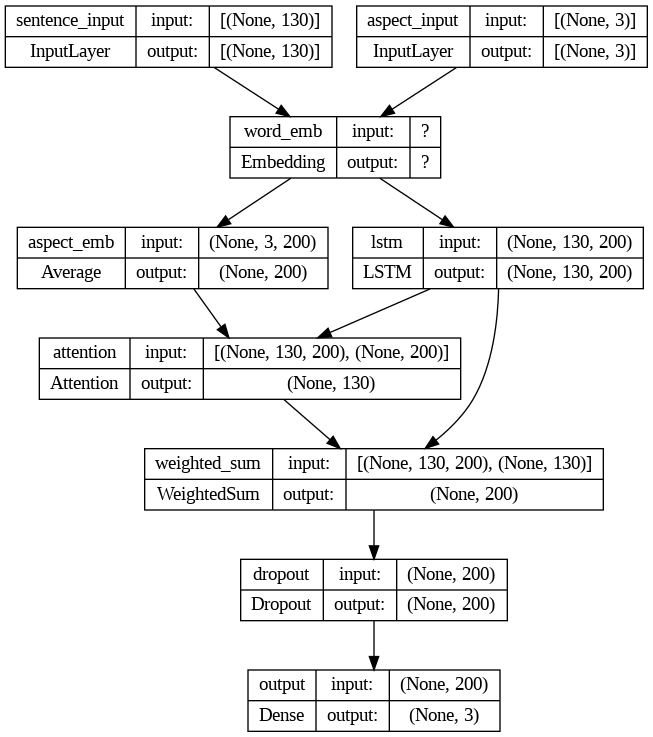

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss = 'categorical_crossentropy',metrics = "categorical_accuracy")
num_train_epochs = 50


In [ ]:
train = tf.data.Dataset.from_tensor_slices(({"sentence_input":X_train_text_encoded,"aspect_input":X_train_aspect_encoded},{'output':y_train_encoded}))
train = train.batch(8).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

dev = tf.data.Dataset.from_tensor_slices(({"sentence_input":X_dev_text_encoded,"aspect_input":X_dev_aspect_encoded},{'output':y_dev_encoded}))
dev = dev.batch(8).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
    )

In [ ]:
model.fit(
    train,
    validation_data = dev,
    epochs = 20,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/20
1507/1507 [==============================] - 1306s 860ms/step - loss: 0.7296 - categorical_accuracy: 0.6768 - val_loss: 0.7170 - val_categorical_accuracy: 0.6733
Epoch 2/20
1507/1507 [==============================] - 1282s 851ms/step - loss: 0.5841 - categorical_accuracy: 0.7515 - val_loss: 0.7542 - val_categorical_accuracy: 0.6520
Epoch 3/20
1507/1507 [==============================] - 1275s 846ms/step - loss: 0.5036 - categorical_accuracy: 0.7907 - val_loss: 0.8129 - val_categorical_accuracy: 0.6480
Epoch 4/20
1507/1507 [==============================] - 1264s 839ms/step - loss: 0.4445 - categorical_accuracy: 0.8202 - val_loss: 0.8954 - val_categorical_accuracy: 0.6449
Epoch 5/20
1507/1507 [==============================] - 1260s 836ms/step - loss: 0.3936 - categorical_accuracy: 0.8439 - val_loss: 0.9558 - val_categorical_accuracy: 0.6445
Epoch 6/20
1507/1507 [==============================] - 1279s 849ms/step - loss: 0.3460 - categorical_accuracy: 0.8634 - val_loss: 0.99

In [ ]:
# model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/LSTM-memory.h5")

In [36]:
model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/LSTM-memory.h5")

# EVALUATION

In [37]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
  )


In [38]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [39]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/test_300_Quy.json")
sentences, aspects,polarities = sent_asp_data.load()

In [40]:
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [41]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)


In [42]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [43]:
sentences_normalized[:5],aspects_normalized[:5]

(array(['bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất h

In [44]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [45]:
sentences_segments

['bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mì

In [46]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh beo'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh bèo chén'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'giá cả'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều t

In [47]:
X_test_text, X_test_aspect = np.asarray(X_pair)[:,0],np.asarray(X_pair)[:,1]

In [48]:
X_test_text_encoded = encoded(X_test_text,130)
X_test_aspect_encoded = encoded(X_test_aspect,3)


In [49]:
y_test_encoded = [tag2idx[y] for y in polarities]
y_test_encoded = to_categorical(y_test_encoded,num_classes = len(tag2idx))

In [50]:
test_tf = tf.data.Dataset.from_tensor_slices({"sentence_input":X_test_text_encoded,"aspect_input":X_test_aspect_encoded}).batch(8)

In [51]:
y_test_pred = np.argmax(model.predict(test_tf),axis=-1)
y_test_pred = y_test_pred.reshape((1,-1))[0]

302/302 [==============================] - 22s 62ms/step


In [52]:
y_temp = np.asarray(list(map(lambda x: tag2idx[x],polarities)))
y_temp

array([2, 2, 2, ..., 1, 1, 2])

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_test_pred,digits =4 ))

              precision    recall  f1-score   support

           0     0.4333    0.1585    0.2321       164
           1     0.5697    0.6223    0.5949       932
           2     0.6963    0.7058    0.7011      1319

    accuracy                         0.6364      2415
   macro avg     0.5665    0.4956    0.5094      2415
weighted avg     0.6296    0.6364    0.6282      2415

